# Word2Vec model

In [350]:
import spacy
import scispacy
import pickle
import numpy as np
import pandas as pd
import re
import en_ner_bionlp13cg_md
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('classic')

A list of tokenized sentences is needed for a Word2Vec model 

In [3]:
nlp = en_ner_bionlp13cg_md.load()

In [4]:
#tokenizer split on '/' also
infixes = nlp.Defaults.infixes + (r'''/''',)
infix_regex = spacy.util.compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_regex.finditer

In [5]:
#merge identified entitites into chunks, this is important for multi-word proteins 
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents)

In [21]:
#had turned on noun chunks but model was better with it disabled
merge_nouns = nlp.create_pipe("merge_noun_chunks")
nlp.add_pipe(merge_nouns)

In [65]:
#add the sentencizer pipe component from spacy
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [56]:
#define the keep token rules: the token needs to be more than 1 character and not a stop word
def keep_token(t):
    #return (t.ent_type != 0 or t.pos_ == "NOUN" or t.pos_ == "PROPN" or t.pos_ == "VERB") 
    return (t.__len__() > 1 and t.is_stop == False)

In [8]:
import os
os.chdir('/Volumes/BethMac/Metis Proj 4 data/')

In [9]:
with open('title_abstract_docs_list.pickle', 'rb') as read_file:
    abstracts = pickle.load(read_file)

In [10]:
len(abstracts)

337871

In [11]:
import re

In [12]:
#remove new line characters from abstracts
abstracts = list(map(lambda x: re.sub('\\n',' ', x),abstracts))

In [71]:
nlp_abstracts = nlp.pipe(abstracts, disable=["parser","merge_nouns"])

In [72]:
#build the sentence tokens list
sentence_tokens = []
count = 0

for doc in nlp_abstracts:
    sentences = doc.sents
    for s in sentences:
        sentence_tokens.append([re.sub('[)(]|\-$','',t.lemma_.lower()) for t in s if keep_token(t)])
    count += 1
    if count%1000 == 0:
        print(count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [74]:
sentence_tokens[0]

['ultrastructural',
 'localization',
 "5'nucleotidase",
 'human',
 'normal',
 "malignant lymphoid cells.5'nucleotidase ec 3.1.3.5",
 'purine',
 'pathway',
 'enzyme',
 'occur',
 'cellular',
 'ectoenzyme']

In [75]:
#with open('sentence_tokens.pickle', 'wb') as write_file:
#    pickle.dump(sentence_tokens,write_file)

Train a small Word2Vec model. It's a CBOW model by default, and I used a window of 2 words on either side of the focus word and a vector size of 30. Words in less than 20 documents were excluded.

In [351]:
from gensim.models import Word2Vec

In [85]:
w2v_model = Word2Vec(sentence_tokens,
                     min_count=20,
                     window=2,
                     size=30,
                     workers=3)

In [240]:
#with open('w2v_model.pickle', 'wb') as write_file:
#    pickle.dump(w2v_model, write_file)

In [ ]:
with open('w2v_model.pickle', 'rb') as read_file:
    w2v_model = pickle.load(read_file)

Looked at similarities between words

In [356]:
w2v_model.wv.most_similar(positive=["piwil4"])

[('linc00261', 0.9541552066802979),
 ('phf5a', 0.9534187316894531),
 ('mael', 0.9482311010360718),
 ('hoxa6', 0.9390056133270264),
 ('nfix', 0.9303953647613525),
 ('mir-490-5p', 0.9303116798400879),
 ('rnaseh2a', 0.93006432056427),
 ('sulf-1', 0.9300011396408081),
 ('cc10', 0.9284472465515137),
 ('klf13', 0.928395688533783)]

In [354]:
w2v_model.wv.most_similar(positive=["drosha"])

[('ago2', 0.9090682864189148),
 ('dicer', 0.9010425806045532),
 ('dgcr8', 0.8825297355651855),
 ('dicer1', 0.8360365033149719),
 ('auf1', 0.8236735463142395),
 ('sra', 0.8226485252380371),
 ('ogt', 0.8142427206039429),
 ('tsg101', 0.8045661449432373),
 ('adar1', 0.8012075424194336),
 ('hur', 0.8008813261985779)]

In [89]:
w2v_model.wv.most_similar(positive=["androgen"])

[('estrogen', 0.9045140743255615),
 ('oestrogen', 0.836421549320221),
 ('progestin', 0.8155102729797363),
 ('ar', 0.8034884929656982),
 ('human androgen', 0.7988086938858032),
 ('progesterone', 0.7933131456375122),
 ('castration', 0.7886373400688171),
 ('antiestrogen', 0.783228874206543),
 ('androgen receptor', 0.7777259349822998),
 ('estradiol', 0.7774113416671753)]

In [90]:
w2v_model.wv.doesnt_match(['smad', 'stat', 'caspase'])

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'caspase'

In [339]:
w2v_model.wv.most_similar(positive=['stat', 'tgfb'], negative=['smad'])

[('janus kinase', 0.8022024631500244),
 ('jak', 0.7566204071044922),
 ('ikbke', 0.7434075474739075),
 ('jak2-stat3', 0.7219303846359253),
 ('jak-stat', 0.7154008150100708),
 ('janus kinases', 0.71361243724823),
 ('janus tyrosine kinases', 0.7063664197921753),
 ('nod2-mediated', 0.7057802081108093),
 ('socs-1', 0.702123761177063),
 ('il1', 0.6968396306037903)]

In [95]:
w2v_model.wv.most_similar(positive=['wnt', 'stat'], negative=['jak'])

[('notch', 0.8736619353294373),
 ('β-catenin', 0.8687324523925781),
 ('hh', 0.8641165494918823),
 ('beta-catenin', 0.845676064491272),
 ('hippo', 0.8436160683631897),
 ('hedgehog', 0.842531681060791),
 ('shh', 0.8196277022361755),
 ('bmp', 0.8134657144546509),
 ('pcp', 0.8090837001800537),
 ('hedgehog-gli', 0.8014574646949768)]

In [96]:
w2v_model.wv.most_similar(positive=['hippo', 'smad'], negative=['tgfb'])

[('network', 0.7880990505218506),
 ('ddr', 0.7822858095169067),
 ('mtorc1', 0.774041473865509),
 ('yap', 0.7661123871803284),
 ('mtorc2', 0.7656790018081665),
 ('ras', 0.7572907209396362),
 ('torc1', 0.735136091709137),
 ('downstream', 0.7350701689720154),
 ('upstream', 0.7267253398895264),
 ('tor', 0.7166546583175659)]

In [108]:
w2v_model.wv.most_similar(positive=['calcium', 'pka'], negative=['camp'])

[('camkii', 0.8278478980064392),
 ('ca²⁺', 0.8230966329574585),
 ('ca2+', 0.8224935531616211),
 ('girk', 0.8108043670654297),
 ('kca3.1', 0.8071615099906921),
 ('katp', 0.8004486560821533),
 ('ip3 receptor', 0.8004202842712402),
 ('plasma membrane ca2+', 0.797620952129364),
 ('bkca', 0.7967962026596069),
 ('neuronal ca2+', 0.7962998747825623)]

In [110]:
w2v_model.wv.doesnt_match(['t-cell', 'b-cell', 'macrophage','neutrophil','neuron'])

'neuron'

In [116]:
w2v_model.wv.most_similar(positive=['integrin', 'cadherin'], negative=['fak'])

[('hspg', 0.8051071763038635),
 ('syndecan', 0.7531814575195312),
 ('ncam', 0.7417287826538086),
 ('importin', 0.735167384147644),
 ('n-glycans', 0.7329444885253906),
 ('plexin', 0.7303943634033203),
 ('integrin receptor', 0.7241027355194092),
 ('heparan sulfate proteoglycans', 0.7180184125900269),
 ('parathyroid hormone receptor', 0.7174355983734131),
 ('ephrin', 0.716456949710846)]

In [118]:
w2v_model.wv.doesnt_match(['integrin', 'cadherin', 'selectin', 'occludin', 'vcam', 'ncam', 'histone'])

'histone'

In [119]:
w2v_model.wv.doesnt_match(['sirt', 'hdac', 'cbp'])

'cbp'

In [332]:
w2v_model.wv.most_similar(positive=['keap1', 'nfkb'], negative=['nrf2'])

[('nik', 0.8875367045402527),
 ('ikkα', 0.8703591823577881),
 ('cjun', 0.8479061126708984),
 ('rel', 0.8435419201850891),
 ('ikk-alpha', 0.8390546441078186),
 ('ikk2', 0.8384244441986084),
 ('ikkβ', 0.8378127217292786),
 ('ikkalpha', 0.8296139240264893),
 ('mekk4', 0.827118456363678),
 ('jak kinases', 0.8263416290283203)]

In [129]:
w2v_model.wv.most_similar(positive=['fos', 'β-catenin'], negative=['tcf'])

[('junb', 0.8578189015388489),
 ('jun', 0.8337555527687073),
 ('c-fos', 0.8277279734611511),
 ('fra-1', 0.8256969451904297),
 ('fra1', 0.8035809397697449),
 ('fosb', 0.8019673824310303),
 ('mapk3', 0.7997921705245972),
 ('protooncogene', 0.7941627502441406),
 ('fra-2', 0.791016161441803),
 ('smad 2', 0.7870793342590332)]

In [443]:
def display_pca_scatterplot(model, words_1, words_2):
    '''
    Plot words from two related lists in PCA dimensions 
    Connect the words at the same index in each list with a line
    '''
   
    words = words_1+words_2
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10),frameon=False)
    plt.scatter(twodim[:len(words_1),0], twodim[:len(words_1),1], c=colors[0], s=50)
    for word, (x,y) in zip(words_1, twodim[0:len(words_1)]):
        plt.text(x+0.2, y-0.12, word, fontsize=17)
        
    plt.scatter(twodim[len(words_1):,0], twodim[len(words_1):,1], c=colors[1], s=50)
    for word, (x,y) in zip(words_2, twodim[len(words_1):]):
        plt.text(x+0.2, y-0.12, word, fontsize=17)
        
    for pos1, pos2 in zip(twodim[0:len(words_1)],twodim[len(words_1):]):
        plt.plot([pos1[0],pos2[0]],[pos1[1],pos2[1]],c='grey',alpha=0.6)
    

In [357]:
colors = plt.cm.cool(np.linspace(0,1,2)) 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


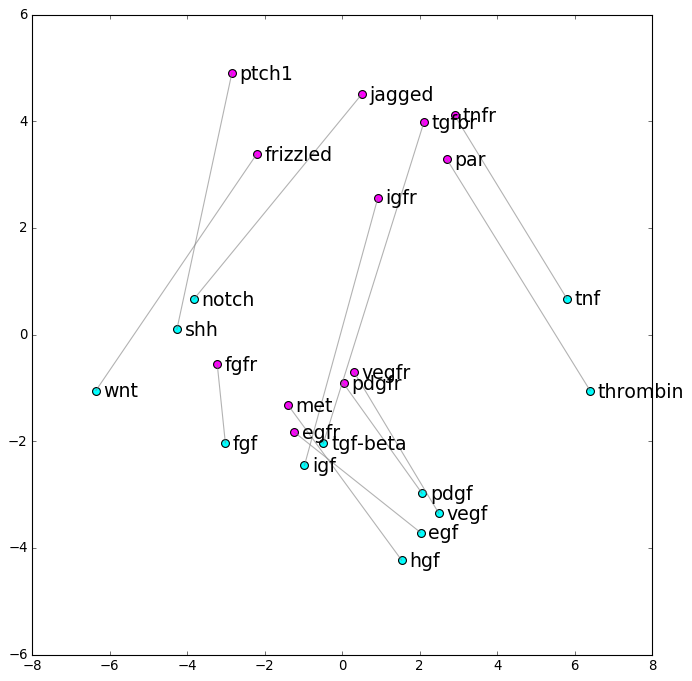

In [447]:
display_pca_scatterplot(w2v_model.wv, 
                        ['tgf-beta','shh','egf','vegf','fgf','pdgf','tnf','igf','thrombin','wnt','hgf','notch'],['tgfbr','ptch1','egfr','vegfr','fgfr','pdgfr','tnfr','igfr','par','frizzled','met','jagged'])

#plt.savefig('ligands_receptors_2.jpg')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


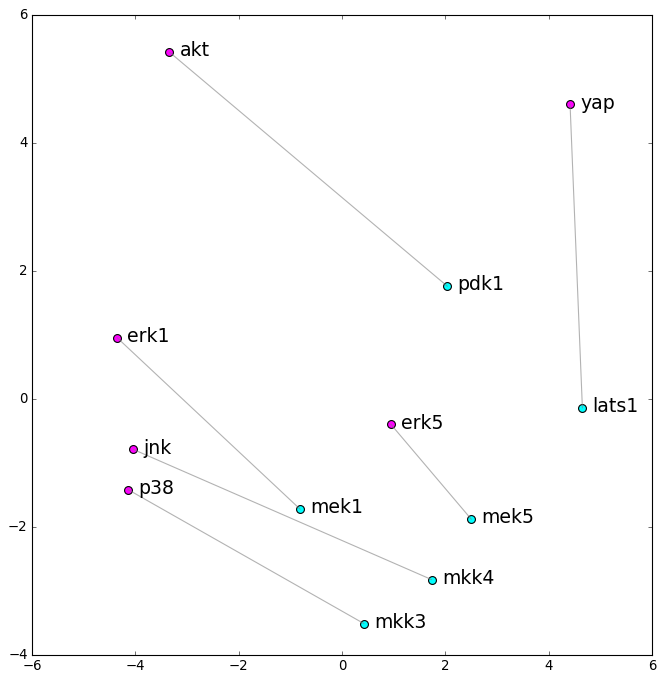

In [360]:
display_pca_scatterplot(w2v_model.wv, 
                        ['mek1','pdk1','mkk4','mkk3','mek5','lats1'],['erk1','akt','jnk','p38','erk5','yap'])
plt.savefig('kinases.jpg')

More word comparisons

In [218]:
w2v_model.wv.most_similar(positive=['actin', 'tubulin'], negative=['f-actin'])

[('covalent', 0.8485742211341858),
 ('microtubule', 0.8032900094985962),
 ('hdac6', 0.7520396113395691),
 ('catalysis', 0.7511951923370361),
 ('sumo', 0.7480200529098511),
 ('isoprenylation', 0.7408669590950012),
 ('v-atpase', 0.739966869354248),
 ('p53-mdm2', 0.7331105470657349),
 ('cdk', 0.7321823835372925),
 ('intramolecular', 0.7314904928207397)]

In [233]:
w2v_model.wv.most_similar(positive=['trpv1', 'sodium'], negative=['calcium'])

[('trpv3', 0.8010115623474121),
 ('cardiac sodium', 0.7993009090423584),
 ('trpm8', 0.7888839244842529),
 ('opener', 0.7840880751609802),
 ('task-1', 0.7666166424751282),
 ('ca2+-channel', 0.7648312449455261),
 ('romk', 0.7630276679992676),
 ('task-3', 0.761641263961792),
 ('nav1.2', 0.7615337371826172),
 ('cardiac k+', 0.7614700794219971)]

In [345]:
w2v_model.wv.most_similar(positive=['glut4', 'glutamate'], negative=['glucose'])

[('ampar', 0.7801319360733032),
 ('synaptic sites', 0.7784178256988525),
 ('aqp2', 0.7709223031997681),
 ('ryanodine receptor', 0.7682939171791077),
 ('galphaq/11', 0.7642937302589417),
 ('presynaptic terminal', 0.7620334625244141),
 ('ampa receptors', 0.7618232369422913),
 ('synaptotagmin', 0.7517701983451843),
 ('sarcoplasmic reticulum', 0.7509982585906982),
 ('aquaporin-2', 0.7491650581359863)]

In [239]:
w2v_model.wv.most_similar(positive=['camp', 'cgmp'], negative=['adenyl cyclase'])

[('inositol phosphate', 0.7763963937759399),
 ('dag', 0.74626624584198),
 ('nitric oxide', 0.7407645583152771),
 ('extracellular adenosine', 0.7360578775405884),
 ('aldosterone', 0.7345423698425293),
 ('mitochondrial atp', 0.7312528491020203),
 ('intracellular ca2', 0.7297405004501343),
 ('diacylglycerol', 0.7243880033493042),
 ('ins1,4,5p3', 0.723926842212677),
 ('atp', 0.7187300324440002)]

In [246]:
w2v_model.wv.most_similar(positive=['mitochondria', 'endoplasmic reticulum'], negative=['energy'])

[('er-stress', 0.7929482460021973),
 ('outer mitochondrial membrane', 0.7428703904151917),
 ('omm', 0.7249677181243896),
 ('er membrane', 0.7182671427726746),
 ('cytosol', 0.7180137634277344),
 ('bak', 0.7085184454917908),
 ('cytoplasm', 0.7074488997459412),
 ('mlkl', 0.705944299697876),
 ('nucleoplasmic', 0.7032440900802612),
 ('cytoplasmic membrane', 0.7011617422103882)]

In [259]:
w2v_model.wv.most_similar(positive=['cancer', 'alzheimer'], negative=['p53'])

[('cardiovascular', 0.7808181643486023),
 ('neurodegenerative', 0.7685712575912476),
 ('neurological', 0.7679355144500732),
 ('neuropsychiatric', 0.766158401966095),
 ('cardiovascular disease', 0.7636638283729553),
 ('psychiatric', 0.751503586769104),
 ('diabete', 0.7447019219398499),
 ('diabetes', 0.7409890294075012),
 ('alcoholism', 0.7381901144981384),
 ('atherosclerosis', 0.7346017360687256)]

In [452]:
w2v_model.wv.most_similar(positive=['elastin', 'laminin'], negative=['collagen'])

[('perlecan', 0.875863254070282),
 ('laminin-332', 0.8604204654693604),
 ('collagen iv', 0.8503476977348328),
 ('type iv collagen', 0.8439871072769165),
 ('proteoglycan', 0.8389266133308411),
 ('lumican', 0.8194851875305176),
 ('tnc', 0.8121795654296875),
 ('tenascin', 0.8081210851669312),
 ('laminin-5', 0.807767927646637),
 ('heparan sulfate proteoglycan', 0.806502103805542)]

In [276]:
w2v_model.wv.most_similar(positive=['oncogene'])

[('oncoprotein', 0.8994867205619812),
 ('oncogenic', 0.8045071363449097),
 ('myc', 0.8009227514266968),
 ('proto', 0.7801446318626404),
 ('mycn', 0.7675319910049438),
 ('k-ras', 0.7450345158576965),
 ('evi1', 0.7422837018966675),
 ('kras', 0.7420530915260315),
 ('e1a', 0.7231967449188232),
 ('pax5', 0.7200646996498108)]

In [277]:
w2v_model.wv.most_similar(positive=['tau'])

[('tdp-43', 0.8199190497398376),
 ('alpha-synuclein', 0.8193961381912231),
 ('α-synuclein', 0.8084140419960022),
 ('synuclein', 0.7911438941955566),
 ('snca', 0.7592361569404602),
 ('intraneuronal', 0.7505019307136536),
 ('crmp2', 0.7277055978775024),
 ('p-tau', 0.7251601815223694),
 ('α-syn', 0.723549485206604),
 ('misfolding', 0.7218120694160461)]

In [278]:
w2v_model.wv.most_similar(positive=['growth'])

[('proliferation', 0.8489096760749817),
 ('motility', 0.7852169871330261),
 ('invasiveness', 0.7828394174575806),
 ('angiogenesis', 0.7763574123382568),
 ('invasion', 0.7500278949737549),
 ('migration', 0.7455548644065857),
 ('stemness', 0.7272424697875977),
 ('outgrowth', 0.7027292251586914),
 ('survival', 0.6988718509674072),
 ('tumorigenicity', 0.689399778842926)]

In [279]:
w2v_model.wv.most_similar(positive=['apoptosis'])

[('death', 0.8679466247558594),
 ('senescence', 0.8214303851127625),
 ('necrosis', 0.818720281124115),
 ('proliferation', 0.8102151155471802),
 ('autophagy', 0.7970517873764038),
 ('ferroptosis', 0.7884844541549683),
 ('cytostasis', 0.7838461995124817),
 ('apoptotic', 0.7623265981674194),
 ('viability', 0.7511582374572754),
 ('necroptosis', 0.7473785281181335)]

In [284]:
w2v_model.wv.most_similar(positive=['stem cell', 'neuron'],negative=['regeneration'])

[('nociceptor', 0.7048476338386536),
 ('photoreceptor', 0.7045892477035522),
 ('olfactory', 0.6770423054695129),
 ('melanopsin', 0.6665627360343933),
 ('cell', 0.6661820411682129),
 ('neural cells', 0.6617079973220825),
 ('thymocyte', 0.6564895510673523),
 ('astrocyte', 0.6523788571357727),
 ('interneuron', 0.6499875783920288),
 ('excitatory synapses', 0.6479549407958984)]

In [292]:
w2v_model.wv.most_similar(positive=['brain', 'blood'],negative=['heart'])

[('extravascular', 0.7246816158294678),
 ('csf', 0.7202889323234558),
 ('cerebrospinal', 0.709128737449646),
 ('lm', 0.6979690790176392),
 ('lymph', 0.6959240436553955),
 ('fluid', 0.6939764022827148),
 ('amniotic', 0.6816660165786743),
 ('saliva', 0.677760124206543),
 ('microbiome', 0.6757568717002869),
 ('salivary', 0.6738871932029724)]

In [293]:
#w2v_model.wv.save('w2v_gensim_save_method.model')

In [352]:
model = Word2Vec.load("w2v_gensim_save_method.model") 

AttributeError: module 'gensim.utils' has no attribute 'open'

In [294]:
w2v_model.wv.doesnt_match(['brain', 'liver', 'lung', 'skin', 'patient'])

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'patient'

In [295]:
w2v_model.wv.doesnt_match(['adenosine', 'tyrosine', 'serine', 'proline'])

'adenosine'

In [296]:
w2v_model.wv.doesnt_match(['serotonin', 'dopamine', 'gaba', 'ach', 'gh'])

'gh'

In [299]:
w2v_model.wv.most_similar(positive=['insulin', 'lipid'],negative=['sugar'])

[('leptin', 0.7714312076568604),
 ('no-cgmp', 0.7335880994796753),
 ('igf-1', 0.728884220123291),
 ('ngf', 0.725912868976593),
 ('bdnf-trkb', 0.7246143221855164),
 ('hepatic insulin', 0.7234041690826416),
 ('s1p', 0.7180932760238647),
 ('igf-i', 0.7009556293487549),
 ('neurotrophin', 0.6949155330657959),
 ('endothelial', 0.6910805106163025)]

In [303]:
w2v_model.wv.most_similar(positive=['adiponectin', 'sugar'],negative=['fat'])

[('kinin', 0.8138394355773926),
 ('ghrelin', 0.7855609655380249),
 ('adenosine', 0.7820999026298523),
 ('extracellular nucleotides', 0.7794912457466125),
 ('eet', 0.7719882726669312),
 ('rve1', 0.7699036598205566),
 ('α-msh', 0.7681056261062622),
 ('cyslts', 0.7615867853164673),
 ('lxa4', 0.7600436806678772),
 ('prostanoid', 0.7567172646522522)]

In [337]:
w2v_model.wv.most_similar(positive=['pancreas', 'erythropoietin'],negative=['insulin'])

[('fetal liver', 0.7460353374481201),
 ('uterus', 0.7362096905708313),
 ('gonad', 0.721034049987793),
 ('haematopoietic', 0.7128474712371826),
 ('bm-derived', 0.7006518840789795),
 ('adrenal gland', 0.6998518705368042),
 ('primitive', 0.698593258857727),
 ('hemopoietic', 0.6959096789360046),
 ('haematopoietic stem cells', 0.6943485736846924),
 ('thymus', 0.6824236512184143)]

In [407]:
w2v_model.wv.most_similar(positive=['pd-l1', 'ctla-4'],negative=['pd-1'])

[('hla class i', 0.8676983118057251),
 ('cd80', 0.8658444285392761),
 ('cd5', 0.8618474006652832),
 ('tim-3', 0.855554461479187),
 ('hla-dr', 0.85270094871521),
 ('ccr7', 0.8501997590065002),
 ('b7-h1', 0.8485901355743408),
 ('cd86', 0.8472750782966614),
 ('cd7', 0.8357675671577454),
 ('cd19', 0.835611879825592)]

In [411]:
w2v_model.wv.most_similar(positive=['histone', 'rna'],negative=['dna'])

[('drosha', 0.7889699339866638),
 ('m6a', 0.7710211873054504),
 ('sra', 0.7671451568603516),
 ('posttranscriptionally', 0.7131240367889404),
 ('ago2', 0.69962078332901),
 ('transcript', 0.6956264972686768),
 ('utr', 0.6948648691177368),
 ('star', 0.6844633221626282),
 ('snorna', 0.6826021671295166),
 ("3'-utr", 0.6807464957237244)]

In [361]:
w2v_model.wv.most_similar(positive=['androgen', 'breast cancer'], negative=['prostate cancer'])

[('estrogen', 0.9158849716186523),
 ('oestrogen', 0.8687738180160522),
 ('antiestrogen', 0.8297780156135559),
 ('tamoxifen', 0.8119247555732727),
 ('progestin', 0.792025089263916),
 ('ar', 0.7741833925247192),
 ('hormone', 0.7732338905334473),
 ('endocrine', 0.7502608895301819),
 ('androgen receptor', 0.7492418885231018),
 ('gc', 0.7469851970672607)]

In [428]:
w2v_model.wv.most_similar(positive=['covid-19'])

[('lymphadenopathy', 0.9026530385017395),
 ('cgvhd', 0.8918194770812988),
 ('toxoplasmosis', 0.8872932195663452),
 ('gout', 0.8772332668304443),
 ('agvhd', 0.8755866289138794),
 ('septicemia', 0.8689640164375305),
 ('silicosis', 0.8675581216812134),
 ('ards', 0.8629375696182251),
 ("crohn's disease", 0.8621755242347717),
 ('hepatitis c', 0.8579164147377014)]

In [434]:
w2v_model.wv.doesnt_match(['covid-19','hiv','herpes','ebv','influenza','bacteria'])

'covid-19'

In [435]:
w2v_model.wv.doesnt_match(['hif','jun','creb','smad','gata','hoxb13','angii'])

'angii'

In [372]:
w2v_model.wv.most_similar(positive=['shh', 'hes1'], negative=['notch'])

[('hes5', 0.9020042419433594),
 ('gli2', 0.8858749866485596),
 ('gli1', 0.8796781897544861),
 ('gli-1', 0.8783226609230042),
 ('hey1', 0.8776895999908447),
 ('wnt4', 0.8467684984207153),
 ('hes-1', 0.8421448469161987),
 ('pax7', 0.8263850212097168),
 ('gli3', 0.8238429427146912),
 ('dkk2', 0.8233767747879028)]

In [377]:
w2v_model.wv.most_similar(positive=['histamine', 'neutrophil'], negative=['eosinophil'])

[('fmlp', 0.8725319504737854),
 ('fmet-leu-phe', 0.8660200834274292),
 ('paf', 0.8609027862548828),
 ('extracellular atp', 0.8470888733863831),
 ('fmlf', 0.8434070944786072),
 ('bradykinin', 0.8408018946647644),
 ('epinephrine', 0.8388182520866394),
 ('5ht', 0.838687002658844),
 ('methacholine', 0.8239145278930664),
 ('acetylcholine', 0.8214134573936462)]

In [393]:
w2v_model.wv.most_similar(positive=['clock'])

[('circadian', 0.8755050897598267),
 ('oscillator', 0.8379597067832947),
 ('rhythm', 0.8198610544204712),
 ('timekeeping', 0.7599442005157471),
 ('rhythmicity', 0.7415726780891418),
 ('circuitry', 0.7378842830657959),
 ('entrainment', 0.7361363172531128),
 ('circuit', 0.7115831971168518),
 ('scn', 0.7113426923751831),
 ('spermatogenesis', 0.709203839302063)]

In [394]:
w2v_model.wv.most_similar(positive=['cilia'])

[('cilium', 0.959104061126709),
 ('photoreceptor', 0.7801337242126465),
 ('dendrite', 0.7544570565223694),
 ('centriolar', 0.7475356459617615),
 ('seminiferous epithelium', 0.7409558296203613),
 ('ciliogenesis', 0.737008273601532),
 ('neuron', 0.7365002036094666),
 ('photoreceptor cells', 0.7330804467201233),
 ('centriole', 0.732792854309082),
 ('nephron', 0.7253248691558838)]

In [395]:
w2v_model.wv.most_similar(positive=['rhodopsin'])

[('transducin', 0.821509599685669),
 ('photopigment', 0.7980531454086304),
 ('melanopsin', 0.7874122858047485),
 ('opsin', 0.7782406210899353),
 ('rho1', 0.7592681646347046),
 ('mosaic', 0.7490711212158203),
 ('vsd', 0.7381170392036438),
 ('tmd', 0.7301325798034668),
 ('recoverin', 0.7291203737258911),
 ('shaker', 0.7234669327735901)]